In [ ]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

d_model = 256
n_tokens = 10
sequence_length = 6
n_heads = 1
dataset = rollout.dataset.InductionDataset(n_tokens, sequence_length)
simpleModel = rollout.models.FlexibleTransformer(d_model, n_tokens, sequence_length, n_heads, n_attn_layers=1)
optimizer = optim.AdamW(simpleModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

simple_train_losses, simple_test_losses = rollout.models.optimize_model(simpleModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.4862475395202637, Test Loss: 2.3510284423828125
Epoch 100: Train Loss: 1.3486533164978027, Test Loss: 1.3365026712417603
Epoch 200: Train Loss: 1.289481520652771, Test Loss: 1.289735198020935
Epoch 300: Train Loss: 1.302837610244751, Test Loss: 1.2885853052139282
Epoch 400: Train Loss: 1.2977895736694336, Test Loss: 1.2576392889022827


In [6]:
d_model = 128
n_heads = 1

complexModel = rollout.models.FlexibleTransformer(d_model, n_tokens, sequence_length, n_heads, n_attn_layers=2)
optimizer = optim.AdamW(complexModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

complex_train_losses, complex_test_losses =  rollout.models.optimize_model(complexModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.482112169265747, Test Loss: 2.384094476699829
Epoch 100: Train Loss: 0.0008684136555530131, Test Loss: 0.0002908423193730414
Epoch 200: Train Loss: 0.0005223345942795277, Test Loss: 0.0002407014835625887
Epoch 300: Train Loss: 8.25650422484614e-05, Test Loss: 8.568507473682985e-05
Epoch 400: Train Loss: 5.695410436601378e-05, Test Loss: 5.8558489399729297e-05


In [7]:
num_simple_params = sum(p.numel() for p in simpleModel.parameters() if p.requires_grad)
num_complex_params = sum(p.numel() for p in complexModel.parameters() if p.requires_grad)
print(f"Simple model has {num_simple_params} parameters")
print(f"Complex model has {num_complex_params} parameters")

Simple model has 268298 parameters
Complex model has 134666 parameters


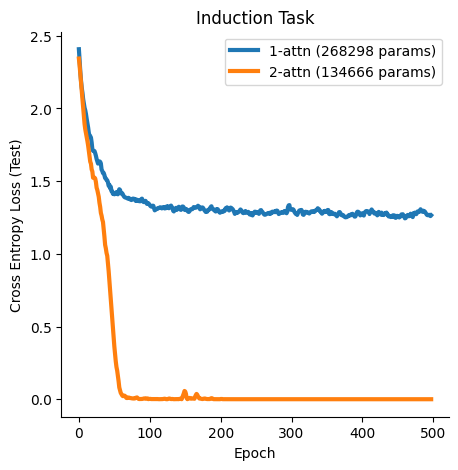

In [8]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(rollout.utils.movmean(np.array(simple_train_losses), 3), label=f"1-attn ({num_simple_params} params)", lw=3)
ax.plot(rollout.utils.movmean(np.array(complex_test_losses), 3), label=f"2-attn ({num_complex_params} params)", lw=3)
ax.set_ylabel("Cross Entropy Loss (Test)")  
ax.legend()
ax.set_title("Induction Task")
ax.set_xlabel("Epoch")
sns.despine()

In [14]:
X, y = dataset.generate_batch(100, type="test")

simple_x, simple_weights = simpleModel.forward_with_weights(X)
complex_x, complex_weights = complexModel.forward_with_weights(X)
y_pred_simple = torch.argmax(simple_x, dim=1)
y_pred_complex = torch.argmax(complex_x, dim=1)

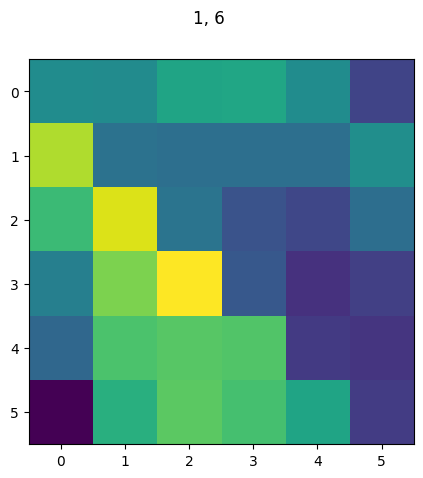

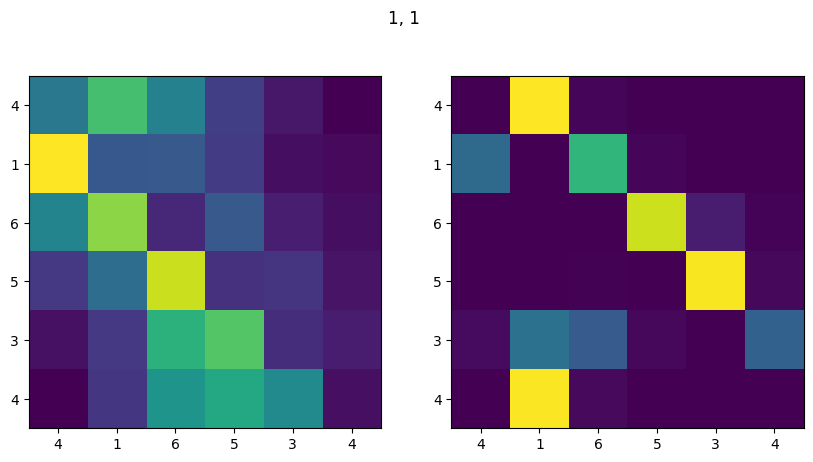

In [17]:
sample = np.random.randint(0, len(y))


fig, ax = plt.subplots(1, len(simple_weights), figsize=(10, 5))
for ix, aw in enumerate(simple_weights):
    plt.imshow(aw[sample])
fig.suptitle(f"{y[sample]}, {y_pred_simple[sample]}")

fig, ax = plt.subplots(1, len(complex_weights), figsize=(10, 5))
for ix, aw in enumerate(complex_weights):
    ax[ix].imshow(aw[sample])
    ax[ix].set_xticks(np.arange(sequence_length), labels=X[sample].numpy())
    ax[ix].set_yticks(np.arange(sequence_length), labels=X[sample].numpy())

fig.suptitle(f"{y[sample]}, {y_pred_complex[sample]}")
plt.show()